In [77]:
import pandas as pd
import numpy as np
import requests
import io

import seaborn as sns

In [36]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 



# Отзывы, поступившие через виджет обратной связи АИС "Мониторинг Госcайтов
 

Данный датасет взят с сайта
https://data.gov.ru/opendata/3117000953-konsol

In [119]:
data = pd.read_csv("data-20150923t1145-structure-20150923t1145_4.csv")

In [120]:
data = data.astype({
    "Дата сайта" : 'datetime64',
    "Дата отзыва" : 'datetime64',
    'Дата ответа куратора': 'datetime64'
})

In [121]:
data = data.rename(columns = {
    "Уровень" : "level",
    "Сайт" : "site_name",
    "Адрес" : "website",
    "Дата сайта" : "date_site",
    "Тип субъекта" : "type_subject",
    "Подведомственность" : "jurisdiction",
    "Дата отзыва" : "date_review",
    "Тип отзыва" : "type_review",
    "Заголовок" : "title",
    "Сообщение" : "text",
    "Ответ" : "answer",
    "Куратор" : "curator",
    "Решение куратора" : "curators_decision",
    "Дата ответа куратора" : "date_curator_review",
    "Статус" : "status",
    "Оценка отзыва" : "review_rang"

})

In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16588 entries, 0 to 16587
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   level                16588 non-null  object        
 1   site_name            16588 non-null  object        
 2   website              16588 non-null  object        
 3   date_site            16588 non-null  datetime64[ns]
 4   type_subject         691 non-null    object        
 5   jurisdiction         15301 non-null  object        
 6   date_review          16588 non-null  datetime64[ns]
 7   type_review          16588 non-null  object        
 8   title                16588 non-null  object        
 9   text                 16585 non-null  object        
 10  answer               15442 non-null  object        
 11  curator              14741 non-null  object        
 12  curators_decision    14267 non-null  object        
 13  date_curator_review  14741 non-

Проверяем и фильтруем тестовые запросы

In [123]:
data = data[~ data.title.str.contains('тестовый отзыв|тестовый запрос')]

#### Проверка пропущенных значений

In [124]:
missing_values = data.isna().sum()
df_null = pd.concat([missing_values,missing_values.apply(lambda x: round(x/data.shape[0],4) * 100)]
                    ,axis = 1,keys = ['null','% null'])

In [125]:
df_null.query('null > 0')

,null,% null
type_subject,15895,95.83
jurisdiction,1287,7.76
text,3,0.02
answer,1145,6.90
curator,1846,11.13
curators_decision,2319,13.98
date_curator_review,1846,11.13
review_rang,16021,96.59


Рассмотрим пропущенные значения, проценто которых составляет более 95 процентов

 - сравним списки сайтов где указан тип субъекта и где не указан

In [126]:
not_null_type = data.dropna(subset = ['type_subject'])['site_name'].unique()
null_type = data[data['type_subject'].isna()]['site_name'].unique()

In [127]:
np.intersect1d(not_null_type, null_type)

array([], dtype=object)

Как видим пересечения множеств нету, то есть в зависимости от сайта определяется указыватеся тип субъекта или нет

In [128]:
data['type_subject'].unique()

array([nan, 'город федерального значения', 'республика', 'область',
       'край', 'автономный округ'], dtype=object)

In [129]:
from enum import Enum


class TypeArea(str,Enum):
    FEDERAL = 'город федерального значения'
    REPUBLIC = 'республика'
    AREA = 'область'
    REGION = 'край'
    AURONOM_REGION = 'автономный округ'

def returt_type_area(name_site:str)->TypeArea:
    """Возвращает тип из перечисления TypeArea по вхождению подстроки"""
    dict_values = {
        'республик':TypeArea.REPUBLIC,
        'област':TypeArea.AREA,
        'край':TypeArea.REGION,
        'края':TypeArea.REGION,
        'округ':TypeArea.AURONOM_REGION
    }
    
    for key,value in dict_values.items():
        if key in name_site.lower():
            return value
    return TypeArea.FEDERAL  

def return_type_category(name_site:str)->str:
    return returt_type_area(name_site).value

In [130]:
null_type_col = data['type_subject'].isna()
data.loc[null_type_col,'type_subject'] = data.loc[null_type_col,'site_name'].apply(return_type_category)

*Итого все типы субъектов занесены, что в дальнейшем поможет в анализе данных*

 - далее рассмотрим оценки отзывов

In [131]:
data['review_rang'].value_counts(dropna = False)

NaN                              16021
Неудовлетворительно                233
Да, очень полезная информация      222
Удовлетворительно                  110
Name: review_rang, dtype: int64

Введем еще одну группу: нет оценки, так как это обратная связь от пользователя

In [132]:
data.loc[data.review_rang.isnull(),'review_rang'] = 'Нет оценки'

 - далее рассмотрим пропуски, связанные с юрисдикцией, скорее всего ее также можно подобрать по смыслу


In [133]:
data['jurisdiction'].value_counts(dropna=False)

Президент        9483
Правительство    5816
NaN              1287
Name: jurisdiction, dtype: int64

Выделим сайты с юрисдикцией президента

In [134]:
list_president_site_name = data[data['jurisdiction']=='Президент']['site_name'].unique()
list_government_site_name = data[data['jurisdiction']=='Правительство']['site_name'].unique()
list_other_site_name = data[data['jurisdiction'].isnull()]['site_name'].unique()

Затем проверим, была ли еще какая-нибудь юрисдикция у данных сайтов

In [135]:
print(data[data['site_name'].isin(list_president_site_name)]['jurisdiction'].unique())
print(data[data['site_name'].isin(list_government_site_name)]['jurisdiction'].unique())

['Президент']
['Правительство']


In [136]:
data[data['site_name'].isin(list_other_site_name)]['site_name'].unique()[:10]

array(['Министерство регионального развития Российской Федерации (Упразднено Указом Президента №612 от 8.09.2014',
       'Официальный сайт Пенсионного фонда Российской Федерации',
       'Правительство Российской Федерации',
       'Управление Федеральной службы по надзору в сфере защиты прав потребителей и благополучия человека по Республике Алтай',
       'Федеральная служба исполнения наказаний по республике Башкортостан',
       'Официальный портал органов власти Чувашской Республики',
       'Официальный портал органов государственной власти Республики Бурятия',
       'Официальный портал Правительства Ростовской области',
       'Официальный сайт Администрации Курской области',
       'Официальный сайт Администрации Приморского края и органов государственной власти'],
      dtype=object)

Видно, что даже у правительства пропуски в данном разделе. Итого заполняем пропуски правительством. Так как данные ведомства находятся в его зоне ответственности

In [137]:
data['jurisdiction'].fillna('Правительство',inplace = True)

 - отзывы без текста

In [138]:
data.query("text.isnull()")

,level,site_name,website,date_site,type_subject,jurisdiction,date_review,type_review,title,text,answer,curator,curators_decision,date_curator_review,status,review_rang
4067,Федеральный,Федеральная налоговая служба,http://www.nalog.ru,2013-05-16,город федерального значения,Правительство,2015-07-05,Идея,БЛАНКИ,NaN,Добрый день! В чем суть Вашего вопроса?,Киселев Владимир Константинович,Обработать,2015-05-18,Обработан,Нет оценки
10321,Федеральный,Федеральная служба судебных приставов,http://www.fssprus.ru,2013-05-16,город федерального значения,Президент,2014-09-19,Идея,Как часто обновляется сайт? Погашеную задолжно...,NaN,Банк данных исполнительных производств формиру...,Ищенко Роман Вячеславович,Обработать,2015-02-25,Обработан,Нет оценки
16468,Активные участники,Федеральная служба по тарифам (Упразднена в со...,http://www.fstrf.ru,2013-05-16,город федерального значения,Правительство,2014-11-03,Благодарность,"сайт четко организован, информация полная, пои...",NaN,Добрый день! Спасибо за Ваш отзыв!,Бердникова Анастасия Андреевна,Обработать,2014-11-03,Обработан,Нет оценки


    - Как видим причина пропусков - некорректная работа сайтов. Два вопроса находятся в title, один вопрос с ошибкой
    - Итого один отзыв удаляем, а в других переносим заголовок в текст

Удалим строку по индексу, для избежания ошибок

In [139]:
data = data.drop(index=[4067])

In [140]:
data.loc[data.text.isnull(),'text'] = data.loc[data.text.isnull(),'title']

 - ответы есть, но куратора и даты отзыва куратора нету

Рассмотрим отзывы, в которых был ответ, но куратор пропущен

In [141]:
data.query('answer.notnull() and curator.isnull()').head()

,level,site_name,website,date_site,type_subject,jurisdiction,date_review,type_review,title,text,answer,curator,curators_decision,date_curator_review,status,review_rang
334,Федеральный,Министерство природных ресурсов и экологии Рос...,http://www.mnr.gov.ru,2013-05-16,город федерального значения,Правительство,2012-09-13,Вопрос,"Хотелось бы узнать, по какой причине на сайте ...","Хотелось бы узнать, по какой причине на сайте ...",Государственный доклад «О состоянии и использо...,NaN,Обработать,NaT,Рассмотрение,Нет оценки
346,Федеральный,Министерство природных ресурсов и экологии Рос...,http://www.mnr.gov.ru,2013-05-16,город федерального значения,Правительство,2013-07-01,Вопрос,Где госдоклад за 2011 г.?,Где госдоклад за 2011 г.?,Добрый день. Со всеми государственными доклада...,NaN,Обработать,NaT,Рассмотрение,Нет оценки
348,Федеральный,Министерство природных ресурсов и экологии Рос...,http://www.mnr.gov.ru,2013-05-16,город федерального значения,Правительство,2013-02-26,Проблема,сайт отвратительный невозможно найти ссылку дл...,сайт отвратительный невозможно найти ссылку дл...,Добрый день. Просим более корректно сформулиро...,NaN,Обработать,NaT,Рассмотрение,Нет оценки
349,Федеральный,Министерство природных ресурсов и экологии Рос...,http://www.mnr.gov.ru,2013-05-16,город федерального значения,Правительство,2013-05-03,Вопрос,Не нашел рубрику обращений граждан. На сайте М...,Не нашел рубрику обращений граждан. На сайте М...,Добрый день. Вы можете обратиться в Минприроды...,NaN,Обработать,NaT,Рассмотрение,Нет оценки
351,Федеральный,Министерство природных ресурсов и экологии Рос...,http://www.mnr.gov.ru,2013-05-16,город федерального значения,Правительство,2013-03-23,Идея,"Хотелось бы прозрачности, непонятно чем занима...","Хотелось бы прозрачности, непонятно чем занима...",Добрый день. С информацией о деятельности Минп...,NaN,Обработать,NaT,Рассмотрение,Нет оценки


In [142]:
data.query('answer.notnull() and curator.isnull()').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 703 entries, 334 to 16497
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   level                703 non-null    object        
 1   site_name            703 non-null    object        
 2   website              703 non-null    object        
 3   date_site            703 non-null    datetime64[ns]
 4   type_subject         703 non-null    object        
 5   jurisdiction         703 non-null    object        
 6   date_review          703 non-null    datetime64[ns]
 7   type_review          703 non-null    object        
 8   title                703 non-null    object        
 9   text                 703 non-null    object        
 10  answer               703 non-null    object        
 11  curator              0 non-null      object        
 12  curators_decision    703 non-null    object        
 13  date_curator_review  0 non-null

Присвоим таким кураторам значение - неизвестный куратор

In [143]:
data.loc[data.answer.notnull() & data.curator.isnull() ,'curator'] = "Неизвестный куратор"

Для того чтобы присвоить даты, посчитаем разницу между датой отзыва и датой ответа

In [144]:
data_delta_date = (data['date_review'] - data['date_curator_review'])

In [145]:
data_delta_date.mode()

0   0 days
dtype: timedelta64[ns]

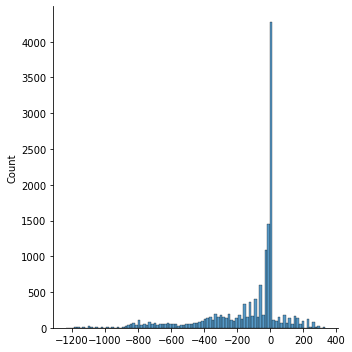

In [146]:
sns.displot(data_delta_date.dt.days)

Итого подавляющее большинство отзывов получают rewiev куратора в тот же день. Поэтому поставим дату rewiev равную дате отзыва

In [147]:
data.loc[data.answer.notnull() & data.date_curator_review.isnull() ,'date_curator_review'] = \
data.loc[data.answer.notnull() & data.date_curator_review.isnull() ,'date_review']

- заполняем оставшиеся пропуски новыми категориями

In [152]:
data.loc[data.curator.isnull(),"curator"] = "Нет куратора"
data.loc[data.answer.isnull(),"answer"] = "Нет ответа"
data.loc[data.curators_decision.isnull(),"curators_decision"] = "Нет решения"

In [154]:
data.loc[data.date_curator_review.isnull(),"date_curator_review"] = \
data.loc[data.date_curator_review.isnull(),"date_review"]